# Toxic Comments Identification

In the modern world, consumers are increasingly paying attention to reviews when faced with a new product, service, and their suppliers. From this point of view, high score and positive reviews help to attract new customers and therefore increase profits, while negative ones can turn off new potential customers. The image of the company in the net is of key importance.
The Wikishop online store is launching a new service, allowing users to edit and supplement product descriptions, like in wiki communities. That is, clients propose their edits and comment on the changes of others. The store needs a tool that will look for toxic comments and submit them for moderation.
Our task is to build a model that, based on the text of the commentary, will classify them into positive and negative ones.
We will carry out the work of training the prediction model on the dataset with markup on the toxicity of edits.

We will get the above data from the following csv file: '/datasets/toxic_comments.csv', the 'text' column of which contains the comment text, while 'toxic' is the target feature.

**The purpose of this study** is to build an optimal model for prediction. The optimal model will be considered the one in which the value of the F1-metric (that is, the harmonic mean of the precision and recall) will be extremely large (minimum 0.75).


**Research progress**:

We will try to build a prediction model on the main data with labeling about toxicity, for this we have to preprocess the data, divide the dataset into 2 samples, explore and possibly adjust the balance of classes, choose the most appropriate model for fitting, fit it in the best way by tuning the appropriate hyperparameters , check the quality of the model on the test sample.


Thus, this project will include the following steps:
* data preprocessing
* model selection and fitting
* model quality check

## Data Processing



In [1]:
import numpy as np  # importing numpy
import pandas as pd  # importing pandas
import seaborn as sns # importing seaborn for plotting
import matplotlib.pyplot as plt # importing matplotlib for plotting
import os.path as path # importing os.path for path handling
from sklearn.linear_model import LogisticRegression # importing Logistic Regression
from sklearn.ensemble import RandomForestClassifier  # importing random Forest
from sklearn.model_selection import train_test_split  # importing the function to split into samples
from sklearn.metrics  import f1_score, make_scorer, confusion_matrix # importing necessary metrics
from sklearn.model_selection import RandomizedSearchCV # importing RandomSearchCV for searching the best parameters
from catboost import CatBoostClassifier # importing Catboost
import warnings # importing warnings to ignore them
warnings.simplefilter("ignore")
import nltk # importing nltk to process the text
from nltk.corpus import stopwords as nltk_stopwords # importing stop/word to exclude
from sklearn.feature_extraction.text import TfidfVectorizer # importing TfidfVectorizer for transforming to vectors
from nltk.stem import WordNetLemmatizer # importing WordNetLemmatizer for lemmatizing
from nltk.tokenize import TweetTokenizer # importing TweetTokenizer for tekenizing
import re # importing the library to for searching with regular expressions
from sklearn.pipeline import Pipeline # importing the class for creating pipelines

Let's make the first impression about the data. To view and analyze, we will read the file in csv format, save it to a variable, and also look at the first 10 rows.

In [2]:
# reading the file and saving todf
try:
    base_path = 'toxic_comments.csv' 
    df = pd.read_csv(base_path) if path.exists(base_path) else pd.read_csv(f'/datasets/{base_path}') # checking the file path
    display(df.head(10))  # getting first 10 rows
except:
     print('File not found') # if no path is correct, an error message will be printed

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


Next, we will get the general information about the dataset and check the quality of the data:

In [3]:
df.info() # пgetting general info on the df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


So, in our dataset there are approx. 160000 objects. The data type in each of them corresponds to the declared feature. Based on the information received, there are no missing values in the dataframe. Let's check this assumption:

In [4]:
df.isna().mean() # checking df for NaNs

text     0.0
toxic    0.0
dtype: float64

Let's also check if there are duplicates in our dataset:

In [5]:
 df.duplicated().sum() # checking df for full duplicates

0

So, our goal is to determine if a comment is toxic. There are two answers to this question - "yes" (1) or "no" (0), thus, our target feature is categorical, and we solve the classification problem. Since there are only two categories, we are talking about a binary classification.
Let's check the balance of classes in the original dataframe:

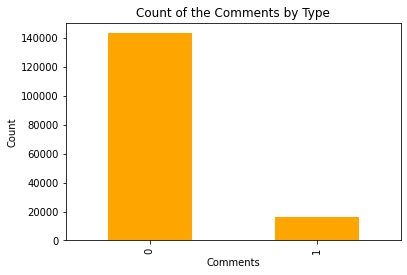

In [6]:
ax = df.groupby('toxic')['toxic'].count().plot.bar(x='toxic',  color = 'orange') # plotting a bar plot
ax.set_ylabel("Count") # setting the name for axis y
ax.set_xlabel("Comments") # setting the name for axis х
ax.set_title('Count of the Comments by Type'); # setting the title


In [7]:
ratio = df['toxic'].mean() # calculation the ratio of toxic comments in df
ratio # checking the result

0.10167887648758234

So, negative comments are approx. 10% of the total number of objects, therefore, the classes are not balanced, their ratio is 1:9. as far as we know, machine learning algorithms are sensitive to class imbalances, so you will "weight" them by adding a special argument when building the model.

Let's divide our dataset into training and test samples in a ratio of 3 to 2. When splitting, we will set the random_state parameter to fix the split results.

In [8]:
features = df.drop(columns=['toxic']) # separating  the features
target = df['toxic']  # separating the target
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.4, stratify=df['toxic'], random_state=12345) # separating 40% for the test sample

In [9]:
print(len(df), len(features_train),  len(features_test), sep='\n') # checking the result
print(len(df) == (len(features_train) + len(features_test)))  #  checking the result

159571
95742
63829
True


The toxic comments in our dataset is about 10%. Let's see if the corresponding samples retained this ratio:

In [10]:
for target in [target_train, target_test]: # interating over the target in samples
    print(target.mean()) # printing the ratio of toxic comments

0.10167951369305007
0.10167792069435523


The ratio of positive and negative comments in the target samples is very close to the same ratio in the general dataset. Therefore, the samples were made correctly.

We know that traditional machine learning models don't work with strings, so we have to do some special processing on comments to convert them from strings to vectors.
At the first stage, we will add a new column to the features with cleared of non-semantic sense symbols and lemmatized text, for this we will define a special function:

In [11]:
nltk.download('wordnet')
# defining a function for comments first-stage processing
def clear_tokenize_lemmatize(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text).split()
    res = ' '.join(text)
    wnl = WordNetLemmatizer()
    tknzr = TweetTokenizer()
    word_list = tknzr.tokenize(res)
    return ' '.join([wnl.lemmatize(w) for w in word_list])
    

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
features_train['lemm_text'] = df['text'].apply(clear_tokenize_lemmatize) # creating a new feature in the df
features_train.head() # проверяем результат

,text,lemm_text
93114,REDIRECT Talk:Balti - City Airport,REDIRECT Talk Balti City Airport
154514,". What happened intermittingly, in which the ...",What happened intermittingly in which the Turk...
71872,"""The article claims that there are 6 primary n...",The article claim that there are primary nomia...
124349,"""\n\n \n\nI supposedly was unblocked. And now ...",I supposedly wa unblocked And now I am still b...
69712,"No, because it's true.",No because it s true


In [13]:
features_test['lemm_text'] = df['text'].apply(clear_tokenize_lemmatize) # creating a new feature in the df
features_test.head() # checking the result

,text,lemm_text
151847,"Comment on Ronald Kaplan page\nhi, I'd like to...",Comment on Ronald Kaplan page hi I d like to k...
52266,3rr \n\nYou have quite clearly violated the 3r...,rr You have quite clearly violated the rr on a...
117514,"I didn't vandalize your user page, idiot.",I didn t vandalize your user page idiot
49033,I'll have a quick re-read and maybe add near t...,I ll have a quick re read and maybe add near t...
9171,This article doesn't suppose to focus on defin...,This article doesn t suppose to focus on defin...


Next, for each sample, we create a corpus of texts and calculate the TF-IDF for them, which evaluates the importance of individual words. Creating a counter of TF-IDF values, we will clear them of the so-called "stop words", that is, those that do not carry a semantic meaning:

In [14]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english')) # loading the stop-words set

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
corpus_train = features_train['lemm_text'].values # creating the train corpus
corpus_test = features_test['lemm_text'].values # creating the test corpus

In [16]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords) # creating a TF-IDF counter

In [48]:
tf_idf = count_tf_idf.fit(corpus_train) # fitting the TF-IDF counter
tf_idf_train = count_tf_idf.transform(corpus_train) # trainforming the train corpus
tf_idf_test = count_tf_idf.transform(corpus_test) # trainforming the test corpus


In [49]:
tf_idf_train.shape # checking the train corpus shape

(95742, 121124)

In [50]:
tf_idf_test.shape # checking the test corpus shape

(63829, 121124)

**Conclusions:**
So, the samples are ready, their size is checked and corresponds to the specified parameters. We have processed the sample objects and converted them into a vector form, that is, the form necessary for training models. Let's move on to the next stage - building and setting the quality of models.

## Modelling

Based on the results of data pocessing, we know that the classes in our target feature are not balanced, their ratio is approximately 1:9 - this means that such an evaluation metric as accuracy for a baseline model will be quite high, so it does not suit us. The most appropriate evaluation criterion for class imbalance in the target attribute is the harmonic mean of the precision and recall of the model, that is, F1 - we should evaluate it according to the task, the value of F1 should be at least 0.75.
We know several models that differ from each other both in quality and in the speed of data processing. We will choose the best of them for our task empirically, varying the hyperparameters and the models themselves. To search for hyperparameters, we will use an alternative to the loop - namely, the RandomizedSearchCV class. We will determine the quality of the best model through cross-validation:

### Random Forest
Random Forest is generally a high quality but low speed prediction model. Among other random forest hyperparameters, besides depth, there is also the number of "evaluator trees" (n_estimators). The higher this parameter, the higher the quality of the model and the lower the speed. Combining a different number of estimators and different depths of trees, we will try to find those hyperparameters, taking into account which the model trained by the cross-validation method will give the best indicator F1:

In [20]:
pipe_rf = Pipeline([('count_tf_idf', TfidfVectorizer()), 
                    ('model', RandomForestClassifier(class_weight='balanced', random_state=12345))]) # creating a pipeline

In [21]:
grid_params_rf = {'model__criterion': ['gini', 'entropy'], 'model__n_estimators': range (10, 100, 5), 
                  'model__max_depth': range (5,11)} # setting the parameters for cross validation

In [22]:
f1 = make_scorer(f1_score) # setting the evaluation metric
grid = RandomizedSearchCV(estimator=pipe_rf, param_distributions=grid_params_rf, scoring=f1, n_jobs=-1, random_state=12345) # creating a Randomizedsearch object
grid.fit(corpus_train, target_train) #   fitting the model
print('F1 of the best random forest is', grid.best_score_, 'with the hyperparameters', grid.best_params_ ) # printing the best result


F1 of the best random forest is 0.3346698696398138 with the hyperparameters {'model__n_estimators': 55, 'model__max_depth': 10, 'model__criterion': 'gini'}


In [23]:
predictions_rf = grid.best_estimator_.predict(corpus_test) # predicting the target
f1_test_rf = f1_score(target_test, predictions_rf)  #  calculating F1
f1_test_rf

0.32464307883302296

So, the quality metric of the random forest, to our surprise, turned out to be more than two times lower than the established threshold: this model definitely does not suit us. Let's move on to testing other models.

### Catboost

So, next on the list there is the Catboost classifier, let's test it in the same procedure as the model above:

In [52]:
model = CatBoostClassifier(random_seed=12345, class_weights=[1, 9]) # creating a model
param_distributions = {'iterations': range (10, 110, 20), 'max_depth': range (1,6), 'learning_rate': [0.1, 0.2, 0.3]}   #  задаём параметры
grid = RandomizedSearchCV(model, param_distributions, scoring=f1, n_jobs=-1, random_state=12345) # creating a Radomizedsearch object
grid.fit(tf_idf_train, target_train, verbose=10) #  fitting the model
print('F1 of the best Catboost is', grid.best_score_, 'with the hyperparameters', grid.best_params_ ) # printing the best result

0:	learn: 0.6540620	total: 1.85s	remaining: 16.6s
9:	learn: 0.5404504	total: 15.3s	remaining: 0us
0:	learn: 0.6524783	total: 1.81s	remaining: 16.3s
9:	learn: 0.5435899	total: 14.9s	remaining: 0us
0:	learn: 0.6523913	total: 1.76s	remaining: 15.8s
9:	learn: 0.5406750	total: 15s	remaining: 0us
0:	learn: 0.6520072	total: 1.71s	remaining: 15.4s
9:	learn: 0.5445207	total: 13.9s	remaining: 0us
0:	learn: 0.6511663	total: 1.56s	remaining: 14s
9:	learn: 0.5408927	total: 13.3s	remaining: 0us
0:	learn: 0.6306835	total: 531ms	remaining: 15.4s
10:	learn: 0.5196875	total: 5.68s	remaining: 9.82s
20:	learn: 0.4697431	total: 10.7s	remaining: 4.6s
29:	learn: 0.4440307	total: 15.1s	remaining: 0us
0:	learn: 0.6376166	total: 534ms	remaining: 15.5s
10:	learn: 0.5224289	total: 5.61s	remaining: 9.69s
20:	learn: 0.4709543	total: 10.7s	remaining: 4.58s
29:	learn: 0.4446568	total: 15.5s	remaining: 0us
0:	learn: 0.6277464	total: 604ms	remaining: 17.5s
10:	learn: 0.5166073	total: 6.01s	remaining: 10.4s
20:	learn: 0

In [53]:
predictions_cb = grid.best_estimator_.predict(tf_idf_test) # predicting the target
f1_test_cb = f1_score(target_test, predictions_cb)  #  calculating F1
f1_test_cb

0.7200000000000001

### Logistic Regression
We know that logistic regression is very high in data processing speed, however, it does not show optimal quality in all samples.
To achieve the maximum F1, let's check how it will change depending on the -'max_iter' hyperparameter - the number of iterations, on the solvers and penalty.

In [37]:
pipe_lr = Pipeline([('count_tf_idf', TfidfVectorizer()), 
                    ('model', LogisticRegression(class_weight='balanced', random_state=42))]) # creating a pipeline

In [38]:
grid_params_lr = {'model__max_iter': range (100,1000, 20), 'model__penalty':
                  ['l1', 'l2'], 'model__solver': ['liblinear']} # setting the parameters for cross validation

In [39]:
f1 = make_scorer(f1_score) # setting the evaluation metric
grid = RandomizedSearchCV(estimator=pipe_lr, param_distributions=grid_params_lr, scoring=f1, n_jobs=-1, random_state=12345) # creating a Randomizedsearch object
grid.fit(corpus_train, target_train) #   fitting the model
print('F1 of the best linear regression is', grid.best_score_, 'with the hyperparameters', grid.best_params_) # printing the best result

F1 of the best linear regression is 0.7501799949483211 with the hyperparameters {'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__max_iter': 140}


In [40]:
predictions_lr = grid.best_estimator_.predict(corpus_test) # predicting the target
f1_test_lr = f1_score(target_test, predictions_lr)  #  calculating F1
f1_test_lr

0.7543564556280696

So, we have almost reached the set F1 threshold on the training sample and slightly improved the result on the test sample. Linear Regression suits us in terms of quality.
Next, using the confusion matrix, we will  analyze the obtained predictions:

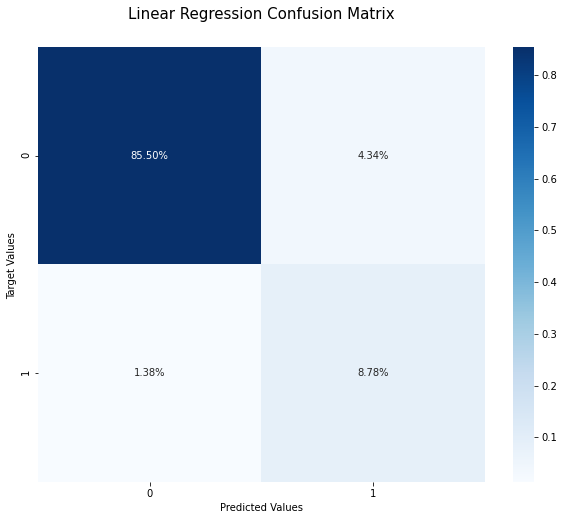

In [41]:
plt.figure(figsize=(10,8)) # setting the figure size
cf_matrix = confusion_matrix(target_test, predictions_lr) # calculating the confusion matrix
ax =  sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues') # plotting the matrix
ax.set_title('Linear Regression Confusion Matrix', y=1.05, size=15) # setting the plot title
ax.set_xlabel('Predicted Values') # setting the name of axis х
ax.set_ylabel('Target Values '); # setting the name of axis y

The confusion matrix clearly shows us that the logistic regression model copes with the task: comments marked by the model as toxic will be sent for moderation. The share of comments that were not toxic, but were marked as such by the model, is small - only 4% of the total sample size, thus, for moderators, this is not such a large amount of additional work. It's more dangerous to skip negative comments and leave them unmoderated, our model only skips 1.6% of them.

**Conclusions:**
So, we have set up and trained three target categorical feature prediction models: random forest, gradient boosting, and logistic regression taking into account the class imbalance. By checking the optimal hyperparameters in each model, we managed to achieve the specified threshold of the F1-measure of 0.75 only by the logistic regression model.
2 other models based on decision trees did not allow reaching and, moreover, exceeding the specified threshold.

## Study Resulst

In the course of this study, we built, adjusted by optimal hyperparameters three models known to us:
 - catboost,
 - random forest,
 - logistic regression.

We checked the results of model tuning on the test data, previously selected from the general dataset, and also balanced the classes to get the maximum F1 quality metric.
According to the results of the comparison, it turned out that the comment class is most qualitatively predicted by **logistic regression, which reached the threshold of the F1 quality metric of 0.75.**

This study was carried out on the basis of the studied models for predicting classes that can work with text, and also taking into account memory limitations. Probably, using a different model or adjusting additional, not yet studied hyperparameters, would allow us to achieve an even higher prediction quality score.